In [1]:
# CELDA 1: Imports y configuración inicial 
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report


In [2]:
# CELDA 2: Cargar dataset procesado 
df = pd.read_csv("../data/processed/cosmetics_processed.csv")

# Revisar columnas y primeras filas
print("Shape:", df.shape)
display(df.head())

# Definir columnas objetivo 
columnas_target = ["Combination", "Dry", "Normal", "Oily", "Sensitive"]

# Definir X e y
X = df.copy()
y = df[columnas_target].astype(int)

# Eliminar columnas target de X (ya están en y)
X = X.drop(columns=columnas_target)
print("X shape:", X.shape, "y shape:", y.shape)

Shape: (1472, 23)


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,...,longitud_texto,contiene_alcohol,contiene_fragancia,contiene_acido,cnt_irritantes,cnt_emolientes,cnt_aceites,cnt_calmantes,ratio_irritantes,ratio_calmantes
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,...,811,1,1,1,5,3,1,1,0.116279,0.023256
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,...,125,0,0,1,0,1,0,0,0.000000,0.000000
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,...,1066,1,0,1,3,5,1,0,0.050000,0.000000
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,...,1590,1,1,0,3,12,1,0,0.037975,0.000000
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,...,2074,0,0,1,3,10,3,3,0.035714,0.035714


X shape: (1472, 18) y shape: (1472, 5)


In [3]:
# CELDA 3: Train / Test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y[columnas_target[0]]
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (1177, 18) X_test: (295, 18)


In [4]:
# CELDA 4: Preprocesador TF-IDF + StandardScaler
columna_texto = "ingredientes_limpios"
columnas_numericas = [
    "cantidad_ingredientes","longitud_texto",
    "contiene_alcohol","contiene_fragancia","contiene_acido",
    "cnt_irritantes","cnt_emolientes","cnt_aceites","cnt_calmantes",
    "ratio_irritantes","ratio_calmantes"
]

# Verificar que existan las columnas necesarias en X_train
faltan = [c for c in [columna_texto] + columnas_numericas if c not in X_train.columns]
if len(faltan)>0:
    raise ValueError(f"Faltan columnas en el dataset procesado: {faltan}")

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words="english")
scaler = StandardScaler()

preprocesador = ColumnTransformer(transformers=[
    ("texto", tfidf, columna_texto),
    ("num", scaler, columnas_numericas)
], remainder="drop")

# Ajustar preprocesador con X_train
preprocesador.fit(X_train)
print("Preprocesador ajustado (TF-IDF vocabulario y scaler).")

Preprocesador ajustado (TF-IDF vocabulario y scaler).


In [5]:
# CELDA 5: Definir pipelines MultiOutput (6 modelos supervisados)
pipeline_lr = Pipeline([("pre", preprocesador), ("clf", MultiOutputClassifier(LogisticRegression(max_iter=400))) ])
pipeline_rf = Pipeline([("pre", preprocesador), ("clf", MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))) ])
pipeline_gb = Pipeline([("pre", preprocesador), ("clf", MultiOutputClassifier(GradientBoostingClassifier(random_state=42))) ])
pipeline_svc = Pipeline([("pre", preprocesador), ("clf", MultiOutputClassifier(SVC(probability=True))) ])
pipeline_knn = Pipeline([("pre", preprocesador), ("clf", MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5))) ])

pipelines = {
    "LR": pipeline_lr,
    "RF": pipeline_rf,
    "GB": pipeline_gb,
    "SVC": pipeline_svc,
    "KNN": pipeline_knn,
}

print("Pipelines preparados:", list(pipelines.keys()))

Pipelines preparados: ['LR', 'RF', 'GB', 'SVC', 'KNN']


In [6]:
# CELDA 6: Entrenar los 6 modelos supervisados (puede tardar)
resultados_entrenamiento = {}

for nombre, pipe in pipelines.items():
    print(f"Entrenando -> {nombre}")
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    f1 = f1_score(y_test, pred, average="macro")
    acc = accuracy_score(y_test, pred)
    resultados_entrenamiento[nombre] = {"f1_macro": f1, "exact_match": acc}
    print(nombre, "F1-macro:", round(f1,4), "Exact match:", round(acc,4))
    print('-'*30)

# Mostrar resumen
tabla_resultados = pd.DataFrame(resultados_entrenamiento).T.sort_values('f1_macro', ascending=False)
display(tabla_resultados)

Entrenando -> LR
LR F1-macro: 0.7432 Exact match: 0.3559
------------------------------
Entrenando -> RF
RF F1-macro: 0.7733 Exact match: 0.4203
------------------------------
Entrenando -> GB
GB F1-macro: 0.735 Exact match: 0.3186
------------------------------
Entrenando -> SVC
SVC F1-macro: 0.7266 Exact match: 0.2983
------------------------------
Entrenando -> KNN
KNN F1-macro: 0.687 Exact match: 0.3593
------------------------------


,f1_macro,exact_match
RF,0.773277,0.420339
LR,0.743154,0.355932
GB,0.735016,0.318644
SVC,0.726559,0.298305
KNN,0.686972,0.359322


C:\Users\rosin\AppData\Local\Temp\ipykernel_14836\3901724053.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tabla_resultados.index, y=tabla_resultados['f1_macro'], palette='Blues_r')
C:\Users\rosin\AppData\Local\Temp\ipykernel_14836\3901724053.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tabla_resultados.index, y=tabla_resultados['exact_match'], palette='Greens_r')


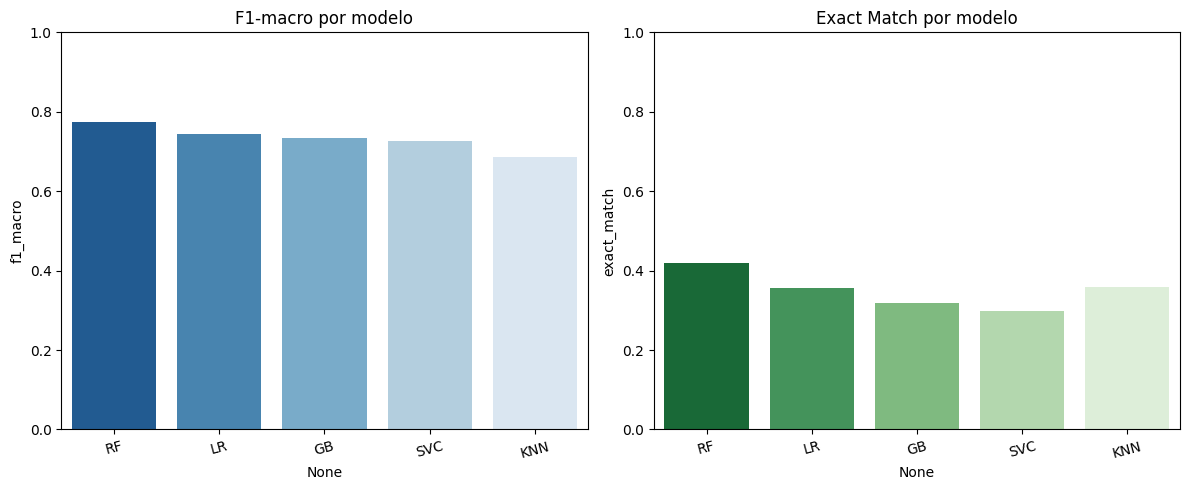

In [7]:
# CELDA 7: Gráficas comparativas (F1-macro y Exact Match) - look profesional
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x=tabla_resultados.index, y=tabla_resultados['f1_macro'], palette='Blues_r')
plt.title('F1-macro por modelo')
plt.ylim(0,1)
plt.xticks(rotation=15)

plt.subplot(1,2,2)
sns.barplot(x=tabla_resultados.index, y=tabla_resultados['exact_match'], palette='Greens_r')
plt.title('Exact Match por modelo')
plt.ylim(0,1)
plt.xticks(rotation=15)

plt.tight_layout()
plt.savefig('../docs/comparativa_modelos_supervisados.png', dpi=150)
plt.show()

In [8]:
# CELDA 8: Seleccionar mejor modelo (por F1-macro)
mejor_nombre = tabla_resultados['f1_macro'].idxmax()
mejor_pipeline = pipelines[mejor_nombre]
print('Mejor modelo (MultiOutput):', mejor_nombre)

Mejor modelo (MultiOutput): RF


C:\Users\rosin\AppData\Local\Temp\ipykernel_14836\4102653613.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=columnas_target, y=precision_vals, palette='Blues')
C:\Users\rosin\AppData\Local\Temp\ipykernel_14836\4102653613.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=columnas_target, y=recall_vals, palette='Greens')


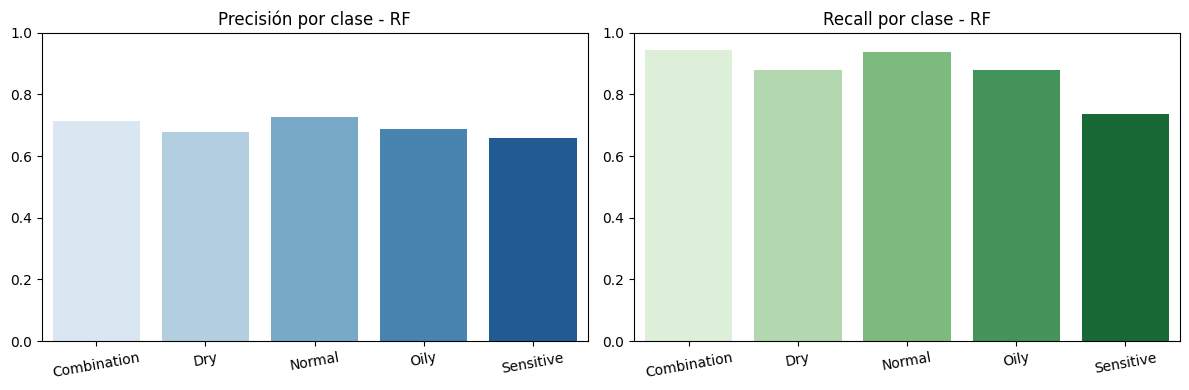

In [9]:
# CELDA 9: Precisión y recall por clase del mejor modelo (MultiOutput)
pred_mejor = mejor_pipeline.predict(X_test)

precision_vals = []
recall_vals = []
for i, clase in enumerate(columnas_target):
    precision_vals.append(precision_score(y_test[clase], pred_mejor[:, i], zero_division=0))
    recall_vals.append(recall_score(y_test[clase], pred_mejor[:, i], zero_division=0))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x=columnas_target, y=precision_vals, palette='Blues')
plt.ylim(0,1)
plt.title(f'Precisión por clase - {mejor_nombre}')
plt.xticks(rotation=10)

plt.subplot(1,2,2)
sns.barplot(x=columnas_target, y=recall_vals, palette='Greens')
plt.ylim(0,1)
plt.title(f'Recall por clase - {mejor_nombre}')
plt.xticks(rotation=10)

plt.tight_layout()
plt.savefig(f'../docs/precision_recall_{mejor_nombre}.png', dpi=150)
plt.show()

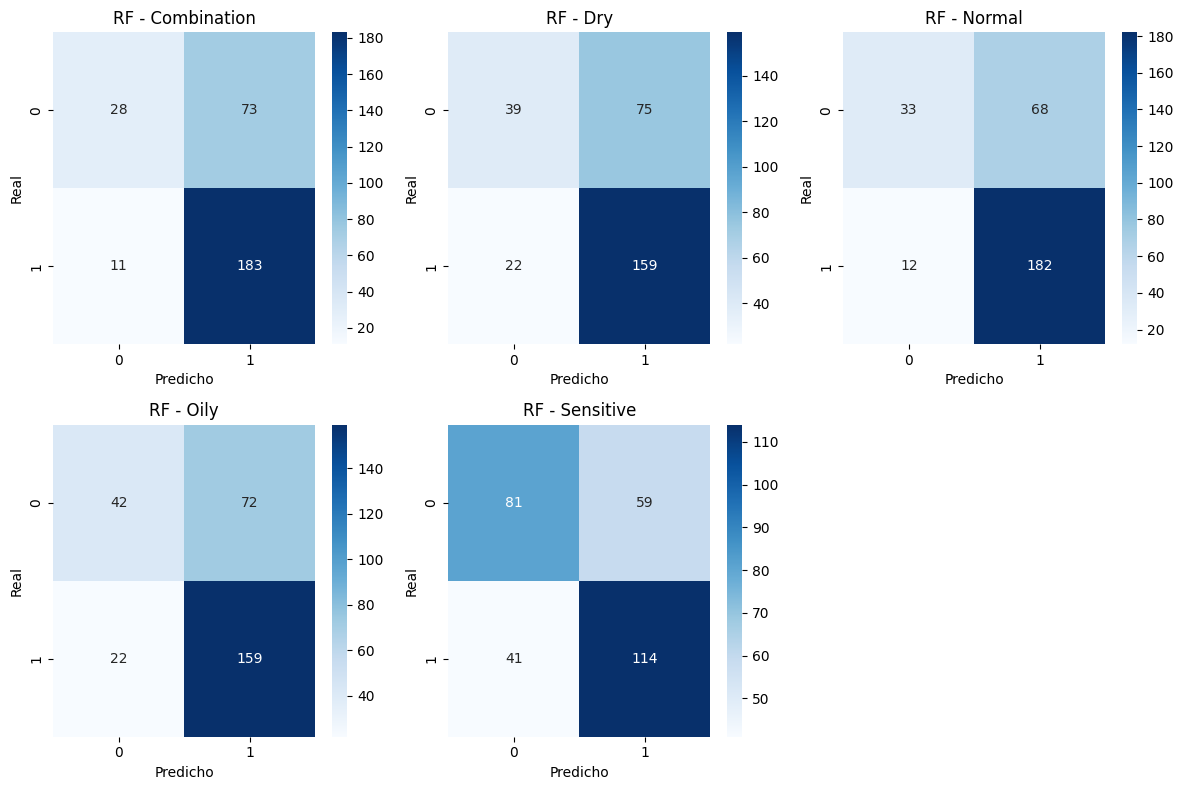

In [10]:
# CELDA 10: Matrices de confusión para el mejor modelo (una por etiqueta)
plt.figure(figsize=(12,8))
for i, etiqueta in enumerate(columnas_target):
    plt.subplot(2,3,i+1)
    cm = confusion_matrix(y_test[etiqueta], pred_mejor[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{mejor_nombre} - {etiqueta}')
    plt.xlabel('Predicho'); plt.ylabel('Real')
plt.tight_layout()
plt.savefig(f'../docs/confusion_matrices_{mejor_nombre}.png', dpi=150)
plt.show()

In [11]:
# CELDA 11: Modelo no supervisado (KMeans) para explorar clusters de formulación
# Usamos representación TF-IDF (texto) y SVD para reducir a 2D
X_tfidf = preprocesador.named_transformers_["texto"].transform(X[columna_texto])
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_2d)

# Proporción de etiquetas por cluster
df_cluster = pd.DataFrame({'cluster': clusters})
df_cluster = pd.concat([df_cluster, y.reset_index(drop=True)], axis=1)
display(df_cluster.groupby('cluster')[columnas_target].mean())

,Combination,Dry,Normal,Oily,Sensitive
cluster,,,,,
0,0.669767,0.609302,0.658140,0.616279,0.511628
1,0.518072,0.530120,0.530120,0.518072,0.481928
2,0.675705,0.634490,0.671367,0.625813,0.530369
3,0.324324,0.351351,0.378378,0.243243,0.189189


In [12]:
# CELDA 12: Entrenar 5 RandomForest independientes (uno por etiqueta) con GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 20]
}

rf_independientes = {}

for etiqueta in columnas_target:
    print('Entrenando RF independiente para:', etiqueta)
    pipeline_bin = Pipeline([('pre', preprocesador), ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))])
    grid = GridSearchCV(pipeline_bin, param_grid, scoring='f1', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train[etiqueta])
    mejor = grid.best_estimator_
    rf_independientes[etiqueta] = mejor
    ruta_modelo = f'../models/rf_ind_{etiqueta.lower()}.pkl'
    with open(ruta_modelo, 'wb') as f:
        pickle.dump(mejor, f)
    print(f'Guardado: {ruta_modelo}   Best CV F1: {grid.best_score_:.4f}')

Entrenando RF independiente para: Combination
Guardado: ../models/rf_ind_combination.pkl   Best CV F1: 0.7984
Entrenando RF independiente para: Dry
Guardado: ../models/rf_ind_dry.pkl   Best CV F1: 0.7608
Entrenando RF independiente para: Normal
Guardado: ../models/rf_ind_normal.pkl   Best CV F1: 0.7915
Entrenando RF independiente para: Oily
Guardado: ../models/rf_ind_oily.pkl   Best CV F1: 0.7565
Entrenando RF independiente para: Sensitive
Guardado: ../models/rf_ind_sensitive.pkl   Best CV F1: 0.6510


In [13]:
# CELDA 13: Predicciones de RF independientes y cálculo de métricas por etiqueta
# Hacemos predicciones y guardamos métricas por etiqueta
preds_ind = {}
metrics_ind = {'f1': {}, 'precision': {}, 'recall': {}}

for etiqueta in columnas_target:
    modelo = rf_independientes[etiqueta]
    pred_i = modelo.predict(X_test)
    preds_ind[etiqueta] = pred_i
    metrics_ind['f1'][etiqueta] = f1_score(y_test[etiqueta], pred_i, zero_division=0)
    metrics_ind['precision'][etiqueta] = precision_score(y_test[etiqueta], pred_i, zero_division=0)
    metrics_ind['recall'][etiqueta] = recall_score(y_test[etiqueta], pred_i, zero_division=0)

# Mostrar resumen rápido
df_ind_metrics = pd.DataFrame(metrics_ind['f1'], index=['F1']).T
df_ind_metrics['precision'] = pd.Series(metrics_ind['precision'])
df_ind_metrics['recall'] = pd.Series(metrics_ind['recall'])
display(df_ind_metrics)

,F1,precision,recall
Combination,0.804598,0.726141,0.902062
Dry,0.750630,0.689815,0.823204
Normal,0.812065,0.738397,0.902062
Oily,0.767726,0.688596,0.867403
Sensitive,0.716049,0.686391,0.748387


,f1_mult,f1_ind,precision_mult,precision_ind,recall_mult,recall_ind
Combination,0.813333,0.804598,0.714844,0.726141,0.943299,0.902062
Dry,0.766265,0.750630,0.679487,0.689815,0.878453,0.823204
Normal,0.819820,0.812065,0.728000,0.738397,0.938144,0.902062
Oily,0.771845,0.767726,0.688312,0.688596,0.878453,0.867403
Sensitive,0.695122,0.716049,0.658960,0.686391,0.735484,0.748387


<Figure size 1000x500 with 0 Axes>

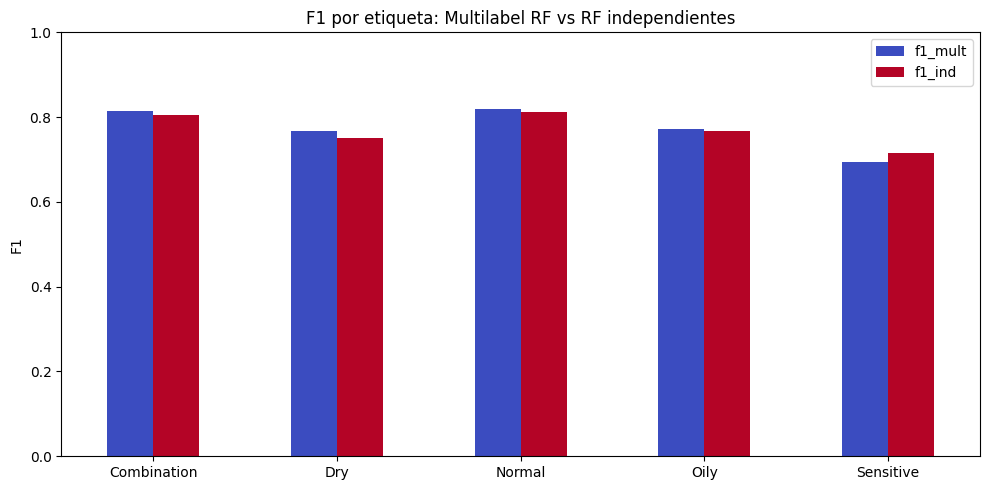

<Figure size 1000x500 with 0 Axes>

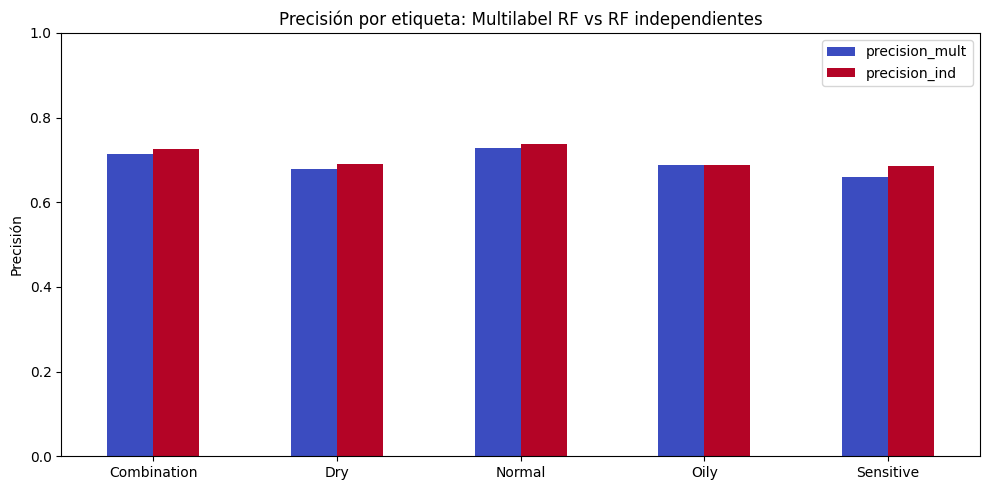

<Figure size 1000x500 with 0 Axes>

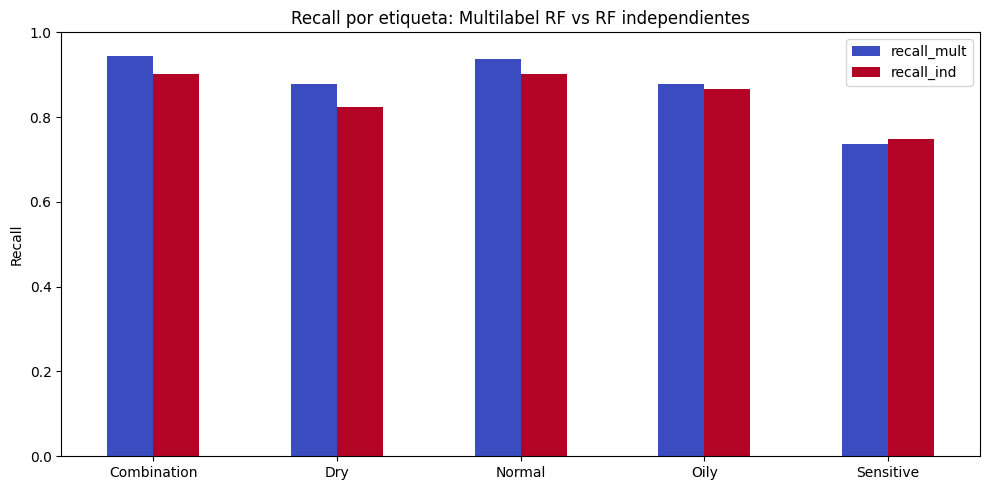

In [14]:
# CELDA 14: Comparativa RF Multilabel vs RF independientes (gráficas y tabla final)
# Predicciones multilabel (usar pipeline_rf si lo entrenaste; sino usar mejor_pipeline si es RF)
if 'pipeline_rf' in globals():
    modelo_multilabel_rf = pipeline_rf
elif 'pipelines' in globals() and 'RF' in pipelines:
    modelo_multilabel_rf = pipelines['RF']
else:
    modelo_multilabel_rf = mejor_pipeline  # fallback

pred_mult = modelo_multilabel_rf.predict(X_test)

# Calcular métricas por etiqueta para multilabel
metrics_mult = {'f1': {}, 'precision': {}, 'recall': {}}
for i, etiqueta in enumerate(columnas_target):
    y_true = y_test[etiqueta]
    y_pred = pred_mult[:, i]
    metrics_mult['f1'][etiqueta] = f1_score(y_true, y_pred, zero_division=0)
    metrics_mult['precision'][etiqueta] = precision_score(y_true, y_pred, zero_division=0)
    metrics_mult['recall'][etiqueta] = recall_score(y_true, y_pred, zero_division=0)

# Construir DataFrame comparativo
df_comp = pd.DataFrame({
    'f1_mult': pd.Series(metrics_mult['f1']),
    'f1_ind': pd.Series(metrics_ind['f1']),
    'precision_mult': pd.Series(metrics_mult['precision']),
    'precision_ind': pd.Series(metrics_ind['precision']),
    'recall_mult': pd.Series(metrics_mult['recall']),
    'recall_ind': pd.Series(metrics_ind['recall']),
})

display(df_comp)

# Graficas bonitas
plt.figure(figsize=(10,5))
df_comp[['f1_mult','f1_ind']].plot(kind='bar', rot=0, figsize=(10,5), colormap='coolwarm')
plt.ylim(0,1)
plt.title('F1 por etiqueta: Multilabel RF vs RF independientes')
plt.ylabel('F1')
plt.tight_layout()
plt.savefig('../docs/comparativa_f1_detallada.png', dpi=150)
plt.show()

plt.figure(figsize=(10,5))
df_comp[['precision_mult','precision_ind']].plot(kind='bar', rot=0, figsize=(10,5), colormap='coolwarm')
plt.ylim(0,1)
plt.title('Precisión por etiqueta: Multilabel RF vs RF independientes')
plt.ylabel('Precisión')
plt.tight_layout()
plt.savefig('../docs/comparativa_precision_detallada.png', dpi=150)
plt.show()

plt.figure(figsize=(10,5))
df_comp[['recall_mult','recall_ind']].plot(kind='bar', rot=0, figsize=(10,5), colormap='coolwarm')
plt.ylim(0,1)
plt.title('Recall por etiqueta: Multilabel RF vs RF independientes')
plt.ylabel('Recall')
plt.tight_layout()
plt.savefig('../docs/comparativa_recall_detallada.png', dpi=150)
plt.show()

In [15]:
# CELDA 15: Tabla final: precision, recall, f1, exact match (multilabel RF and average of independent RFs)
# Exact match only meaningful for multilabel predictions
exact_mult = accuracy_score(y_test, pred_mult)

tabla_final = pd.DataFrame(index=columnas_target)
tabla_final['f1_multilabel'] = pd.Series(metrics_mult['f1'])
tabla_final['precision_multilabel'] = pd.Series(metrics_mult['precision'])
tabla_final['recall_multilabel'] = pd.Series(metrics_mult['recall'])

tabla_final['f1_rf_ind'] = pd.Series(metrics_ind['f1'])
tabla_final['precision_rf_ind'] = pd.Series(metrics_ind['precision'])
tabla_final['recall_rf_ind'] = pd.Series(metrics_ind['recall'])

# Añadir exact match global para multilabel como fila adicional
tabla_final.loc['ExactMatch_Multilabel'] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
tabla_final.at['ExactMatch_Multilabel','f1_multilabel'] = np.nan
tabla_final.at['ExactMatch_Multilabel','precision_multilabel'] = np.nan
tabla_final.at['ExactMatch_Multilabel','recall_multilabel'] = np.nan
tabla_final.at['ExactMatch_Multilabel','f1_rf_ind'] = exact_mult
tabla_final.at['ExactMatch_Multilabel','precision_rf_ind'] = np.nan
tabla_final.at['ExactMatch_Multilabel','recall_rf_ind'] = np.nan

display(tabla_final.round(3))

# Guardar tabla como CSV para incluir en presentaciones
tabla_final.to_csv('../docs/tabla_final_metricas.csv')

,f1_multilabel,precision_multilabel,recall_multilabel,f1_rf_ind,precision_rf_ind,recall_rf_ind
Combination,0.813,0.715,0.943,0.805,0.726,0.902
Dry,0.766,0.679,0.878,0.751,0.690,0.823
Normal,0.820,0.728,0.938,0.812,0.738,0.902
Oily,0.772,0.688,0.878,0.768,0.689,0.867
Sensitive,0.695,0.659,0.735,0.716,0.686,0.748
ExactMatch_Multilabel,NaN,NaN,NaN,0.420,NaN,NaN


In [16]:
# CELDA 16: Guardar pipeline multilabel final (mejor_pipeline si es RF, o pipeline_rf)
ruta_final = '../models/pipeline_mejor_multilabel.pkl'
with open(ruta_final, 'wb') as f:
    pickle.dump(mejor_pipeline, f)
print('Pipeline multilabel guardado en:', ruta_final)

Pipeline multilabel guardado en: ../models/pipeline_mejor_multilabel.pkl
